In [1]:
import os
# Enforces CPU-only execution of torch
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Configure environment to ensure single-threaded execution.
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"
os.environ["OMP_NUM_THREADS"] = "1"

import torch
torch.set_num_threads(1)

from xtr.datasets import BEIR, BEIRDataset, LoTTE, LoTTEDataset
from xtr.config import XTRConfig, XTRModel, XTRScaNNIndexConfig, XTRBruteForceIndexConfig, XTRFAISSIndexConfig
from xtr.utils import xtr_tracker, canonical_index_name
from xtr.modeling.xtr import XTR

import json
from datetime import datetime

/future/u/scheerer/miniconda3/envs/xtr-eval/lib/python3.8/site-packages/beir/util.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
NUM_QUERIES = 5
DOCUMENT_TOP_K = 100
TOKEN_TOP_K = 40_000

In [3]:
dataset = LoTTEDataset(dataset=LoTTE.LIFESTYLE, datasplit="test")
index_config = XTRScaNNIndexConfig()
index_name = canonical_index_name(dataset=dataset, index_config=index_config)
config = XTRConfig(index_name=index_name, model=XTRModel.BASE_EN, index_config=index_config, override=False)

xtr = XTR(config=config, collection=dataset.collection, device=torch.device("cpu"))

#> Loading collection from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/collection.tsv ...
0M 
#> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
#> Got 661 queries. All QIDs are unique.
Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"


In [4]:
from xtr.data.queries import Queries
queries_test = Queries.cast(list(map(lambda x: x[1], dataset.queries))[:NUM_QUERIES])

In [5]:
from xtr.utils.tracker import ExecutionTracker

groups = {
    "Candidate Generation": ["search_batched", "enumerate_scores"],
    "Aggregate Scores": ["get_did2scores", "add_ems", "get_final_score", "sort_scores"]
}

tracker = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings = xtr.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]


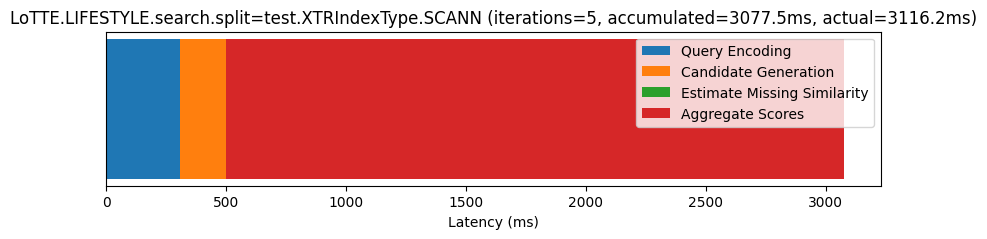

In [6]:
tracker.display_grouped(groups, detailed=False)

In [7]:
from xtr.modeling.xtr_opt import XTROpt

xtr_opt = XTROpt(config=config, collection=dataset.collection, device=torch.device("cpu"))

Loading existing index from /future/u/scheerer/home/data/xtr-eval/indexes/LoTTE.LIFESTYLE.search.split=test.XTRIndexType.SCANN.


[libprotobuf WARNING external/com_google_protobuf/src/google/protobuf/text_format.cc:339] Warning parsing text-format research_scann.ScannConfig: 38:5: text format contains deprecated field "min_cluster_size"
100%|████████████████████████████████████████████████████████████████████████████████████| 23713178/23713178 [01:36<00:00, 246439.17it/s]


In [8]:
tracker_opt = ExecutionTracker(name=index_name, steps=["Query Encoding", "search_batched", "enumerate_scores", "Estimate Missing Similarity",
                                                   "get_did2scores", "add_ems", "get_final_score", "sort_scores"])
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K, tracker=tracker_opt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


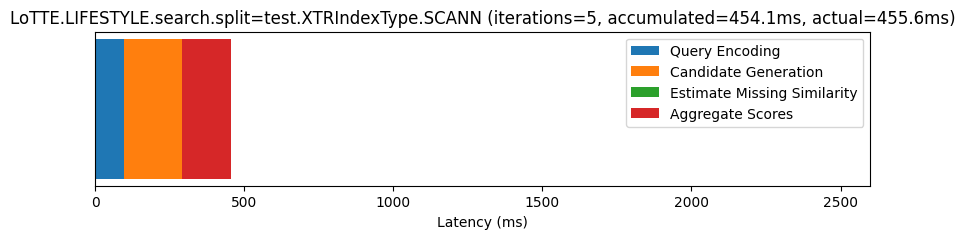

In [9]:
tracker_opt.display_grouped(groups, bound=2600, detailed=False)

In [15]:
def _get_flatten_embeddings(self, batch_text, maxlen, return_last_offset=False):
    batch_embeddings, batch_lengths = self._get_token_embeddings(batch_text, maxlen=maxlen)
    flatten_embeddings = None
    num_tokens = 0
    offsets = [0]
    for _, (embeddings, length) in enumerate(zip(batch_embeddings, batch_lengths)):
        if flatten_embeddings is not None:
            flatten_embeddings = np.append(flatten_embeddings, embeddings[:int(length)], axis=0)
        else:
            flatten_embeddings = embeddings[:int(length)]
        num_tokens += int(length)
        offsets.append(num_tokens)
    assert num_tokens == flatten_embeddings.shape[0]
    if not return_last_offset:
        offsets = offsets[:-1]
    return flatten_embeddings, offsets

xtr_opt._get_flatten_embeddings = lambda *args, **kwargs: _get_flatten_embeddings(xtr_opt, *args, **kwargs)
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


In [13]:
def _batch_search_tokens(self, batch_query, token_top_k, leaves_to_search, pre_reorder_num_neighbors, tracker):
    tracker.begin("Query Encoding")
    all_query_encodings, query_offsets = self._get_flatten_embeddings(batch_query, maxlen=self.config.query_maxlen, return_last_offset=True)
    tracker.end("Query Encoding")

    tracker.begin("search_batched")
    all_neighbors, all_scores = self.searcher.search_batched(
        all_query_encodings, final_num_neighbors=token_top_k, leaves_to_search=leaves_to_search, pre_reorder_num_neighbors=pre_reorder_num_neighbors
    )
    tracker.end("search_batched")

    tracker.begin("enumerate_scores")
    result = [
        (
            [f'q_{i}' for i in range(query_offsets[oid], query_offsets[oid+1])],  # query_id
            all_neighbors[query_offsets[oid]:query_offsets[oid+1]],  # neighbors
            all_scores[query_offsets[oid]:query_offsets[oid+1]],  # scores
        )
        for oid in range(len(query_offsets)-1)
    ]
    tracker.end("enumerate_scores")
    return result

xtr_opt._batch_search_tokens = lambda *args, **kwargs: _batch_search_tokens(xtr_opt, *args, **kwargs)
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


In [12]:
def _estimate_missing_similarity(self, batch_result, tracker):
    tracker.begin("Estimate Missing Similarity")
    # print(batch_result)
    batch_qtoken_to_ems = [dict() for _ in range(len(batch_result))]
    for b_idx, (query_tokens, _, distances) in enumerate(batch_result):
        for token_idx, qtoken in enumerate(query_tokens):
            idx_t = (token_idx, qtoken)
            # Use similarity of the last token as imputed similarity.
            batch_qtoken_to_ems[b_idx][idx_t] = distances[token_idx][-1]
    tracker.end("Estimate Missing Similarity")
    # assert False
    return batch_qtoken_to_ems

xtr_opt._estimate_missing_similarity = lambda *args, **kwargs: _estimate_missing_similarity(xtr_opt, *args, **kwargs)
rankings_opt = xtr_opt.retrieve_docs(queries_test, document_top_k=DOCUMENT_TOP_K, token_top_k=TOKEN_TOP_K)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]
